First, we import the requisite packages.

In [16]:
import cProfile
import matplotlib.pyplot as plt
import numba as nb
import numpy as np
from numba import prange
from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from time import time
from typing import Any, Callable

## Main functions

In the following, we define the functions to compute the responsibility and availability matrices. Other than the function contained in the final package, they feature a ***version*** parameter for performance testing purposes. That way, in each function call, the user can define the version they want to use.

This parameter does not cover the ***JIT***-compiled functions, and so an individual function is needed for every implementation (e.g. default or parallel) of a ***JIT*** function.

In [3]:
def compute_responsibility(S:np.ndarray, R:np.ndarray, A:np.ndarray, 
                           dampfac:float=0.5, version:str="matrix")->np.ndarray:
    '''Computes responsibilities
    Params:
        S: n by n matrix of similarities
        R: n by n matrix of current responsibilities
        A: n by n matrix of current availabilities
        dampfac: Damping factor used to calculate new responsibilities. Acts as weight
                 for the weighted sum of the old and new responsibilities.
        version: For timing purposes. Indicates the version of the function to use.
    Returns:
        A matrix containing the new responsibilities.
    '''
    
    if version == "naive":
        new_R = R.copy()
        n = S.shape[0]
        for i in range(n):
            for k in range(n):
                AS = A[i,:] + S[i,:]
                AS[k] = -np.inf # since maximum is over all k' without k
                new_R[i,k] = S[i,k] - np.max(AS)
    
    elif version == "loop":
        new_R = R.copy()
        
        for k in range(new_R.shape[1]):
            idx = [i for i in range(new_R.shape[1]) if i!=k]
            new_R[:,k] = S[:,k] - np.max(A[:,idx] +
                                         S[:,idx], axis=1)
            
    elif version == "matrix":
        # Prepare the contents of the max
        to_max = A+S
        
        # "Empty" diagonal because it is not used in the max
        np.fill_diagonal(to_max,-np.inf)

        # Get row indices for subsetting the maximum values
        row_indices = np.arange(to_max.shape[0])

        # Get column indices of maximum values
        max_indices = np.argmax(to_max, axis=1)

        # Get maximum of each row
        row_max = to_max[row_indices, max_indices]
        # Assign -inf to previous maxima to get maxima without
        # "actual maxima"
        to_max[row_indices, max_indices] = -np.inf

        # Get secondary maximum of each row
        row_max_without = to_max[row_indices, 
                                     np.argmax(to_max, axis=1)]
        
        # Create matrix of max(a(i, k') + s(i,k'))
        max_AS = np.zeros_like(S) + row_max.reshape(-1,1)
        
        # Modify values of those indices where there were maxima
        # because k' \neq k
        max_AS[row_indices, max_indices] = row_max_without

        return (1-dampfac) * (S - max_AS) + dampfac * R
    
    # Calculate the output R as weighted sum of the old and new R
    new_R = (1-dampfac) * new_R + dampfac * R
        
    return new_R

In [4]:
def compute_responsibility(S:np.ndarray, R:np.ndarray, A:np.ndarray, 
                           dampfac:float=0.5, version:str="matrix")->np.ndarray:
    '''Computes responsibilities
    Params:
        S: n by n matrix of similarities
        R: n by n matrix of current responsibilities
        A: n by n matrix of current availabilities
        dampfac: Damping factor used to calculate new responsibilities. Acts as weight
                 for the weighted sum of the old and new responsibilities.
        version: For timing purposes. Indicates the version of the function to use.
    Returns:
        A matrix containing the new responsibilities.
    '''
    
    if version == "naive":
        new_R = R.copy()
        n = S.shape[0]
        for i in range(n):
            for k in range(n):
                AS = A[i,:] + S[i,:]
                AS[k] = -np.inf # since maximum is over all k' without k
                new_R[i,k] = S[i,k] - np.max(AS)
    
    elif version == "loop":
        new_R = R.copy()
        
        for k in range(new_R.shape[1]):
            idx = [i for i in range(new_R.shape[1]) if i!=k]
            new_R[:,k] = S[:,k] - np.max(A[:,idx] +
                                         S[:,idx], axis=1)
            
    elif version == "matrix":
        # Prepare the contents of the max
        to_max = A+S
        
        # "Empty" diagonal because it is not used in the max
        np.fill_diagonal(to_max,-np.inf)

        # Get row indices for subsetting the maximum values
        row_indices = np.arange(to_max.shape[0])

        # Get column indices of maximum values
        max_indices = np.argmax(to_max, axis=1)

        # Get maximum of each row
        row_max = to_max[row_indices, max_indices]
        # Assign -inf to previous maxima to get maxima without
        # "actual maxima"
        to_max[row_indices, max_indices] = -np.inf

        # Get secondary maximum of each row
        row_max_without = to_max[row_indices, 
                                     np.argmax(to_max, axis=1)]
        
        # Create matrix of max(a(i, k') + s(i,k'))
        max_AS = np.zeros_like(S) + row_max.reshape(-1,1)
        
        # Modify values of those indices where there were maxima
        # because k' \neq k
        max_AS[row_indices, max_indices] = row_max_without

        return (1-dampfac) * (S - max_AS) + dampfac * R
    
    # Calculate the output R as weighted sum of the old and new R
    new_R = (1-dampfac) * new_R + dampfac * R
        
    return new_R

In [5]:
@nb.njit(nogil=True)
def compute_responsibility_jit(S:np.ndarray, R:np.ndarray, A:np.ndarray, 
                           dampfac:float=0.5)->np.ndarray:
    '''Computes responsibilities
    Params:
        S: n by n matrix of similarities
        R:AC n by n matrix of current responsibilities
        A: n by n matrix of current availabilities
        dampfac: Damping factor used to calculate new responsibilities. Acts as weight
                 for the weighted sum of the old and new responsibilities.
        version: For timing purposes. Indicates the version of the function to use.
    Returns:
        A matrix containing the new responsibilities.
    '''
    
    # Prepare the contents of the max
    to_max = A+S

    # "Empty" diagonal because it is not used in the max
    np.fill_diagonal(to_max,-np.inf)

    # Get row indices for subsetting the maximum values
    row_indices = np.arange(to_max.shape[0])
    
    # Get column indices of maximum values
    max_indices = np.zeros(to_max.shape[1], dtype=np.int32)
    for i in range(to_max.shape[1]):
        max_indices[i] = np.argmax(to_max[i,:])
    
    # Get maximum of each row
    row_max = np.zeros(row_indices.shape[0])
    to_max_flat = to_max.flatten()
    for i in range(row_indices.shape[0]):
        idx = int((row_indices[i]+1)*(max_indices[i]+1)-1)
        row_max[i] = to_max_flat[idx]

    # Assign -inf to previous maxima to get maxima without
    # "actual maxima"
    for i in range(row_indices.shape[0]):
        idx = int((row_indices[i])*to_max.shape[1]+max_indices[i])
        to_max_flat[idx] = -np.inf

    max_indices_without = np.zeros(to_max.shape[1])
    for i in range(to_max.shape[1]):
        max_indices_without[i] = np.argmax(to_max_flat.reshape(to_max.shape)[i,:])
    
    # Get secondary maximum of each row
    row_max_without = np.zeros(row_indices.shape[0])
    for i in range(row_indices.shape[0]):
        idx = int((row_indices[i])*to_max.shape[1]+max_indices_without[i])
        row_max_without[i] = to_max_flat[idx]

    # Create matrix of max(a(i, k') + s(i,k'))
    max_AS = np.zeros_like(S) + row_max.reshape(-1,1)
    max_AS_flat = max_AS.flatten()
    
    # Modify values of those indices where there were maxima
    # because k' \neq k
    for i in range(row_indices.shape[0]):
        idx = int((row_indices[i]+1)*(max_indices[i]+1)-1)
        max_AS_flat[idx] = row_max_without[i]

    max_AS = max_AS_flat.reshape(max_AS.shape) 
    return (1-dampfac) * (S - max_AS) + dampfac * R

In [6]:
@nb.njit(parallel=True, nogil=True)
def compute_responsibility_jitp(S:np.ndarray, R:np.ndarray, A:np.ndarray, 
                           dampfac:float=0.5)->np.ndarray:
    '''Computes responsibilities
    Params:
        S: n by n matrix of similarities
        R: n by n matrix of current responsibilities
        A: n by n matrix of current availabilities
        dampfac: Damping factor used to calculate new responsibilities. Acts as weight
                 for the weighted sum of the old and new responsibilities.
        version: For timing purposes. Indicates the version of the function to use.
    Returns:
        A matrix containing the new responsibilities.
    '''
    
    # Prepare the contents of the max
    to_max = A+S

    # "Empty" diagonal because it is not used in the max
    np.fill_diagonal(to_max,-np.inf)

    # Get row indices for subsetting the maximum values
    row_indices = np.arange(to_max.shape[0])
    
    # Get column indices of maximum values
    max_indices = np.zeros(to_max.shape[1], dtype=np.int32)
    for i in prange(to_max.shape[1]):
        max_indices[i] = np.argmax(to_max[i,:])
    
    # Get maximum of each row
    row_max = np.zeros(row_indices.shape[0])
    to_max_flat = to_max.flatten()
    for i in prange(row_indices.shape[0]): 
        row_max[i] = to_max_flat[(row_indices[i]+1)*(max_indices[i]+1)-1]

    # Assign -inf to previous maxima to get maxima without
    # "actual maxima"
    for i in range(row_indices.shape[0]):
        to_max_flat[int((row_indices[i])*to_max.shape[1]+max_indices[i])] = -np.inf

    max_indices_without = np.zeros(to_max.shape[1])
    for i in prange(to_max.shape[1]):
        max_indices_without[i] = np.argmax(to_max_flat.reshape(to_max.shape)[i,:])
    
    # Get secondary maximum of each row
    row_max_without = np.zeros(row_indices.shape[0])
    k = 0
    for i in prange(row_indices.shape[0]): 
        row_max_without[i] = to_max_flat[int((row_indices[i])*to_max.shape[1]+max_indices_without[i])]

    # Create matrix of max(a(i, k') + s(i,k'))
    max_AS = np.zeros_like(S) + row_max.reshape(-1,1)
    max_AS_flat = max_AS.flatten()
    
    # Modify values of those indices where there were maxima
    # because k' \neq k
    for i in range(row_indices.shape[0]): 
        max_AS_flat[int((row_indices[i]+1)*(max_indices[i]+1)-1)] = row_max_without[i]

    max_AS = max_AS_flat.reshape(max_AS.shape) 
    return (1-dampfac) * (S - max_AS) + dampfac * R

In [7]:
@nb.njit(nogil=True)
def compute_responsibility_jit_naive(S:np.ndarray, R:np.ndarray, A:np.ndarray, 
                                     dampfac:float=0.5)->np.ndarray:
    '''Computes responsibilities
    Params:
        S: n by n matrix of similarities
        R: n by n matrix of current responsibilities
        A: n by n matrix of current availabilities
        dampfac: Damping factor used to calculate new responsibilities. Acts as weight
                 for the weighted sum of the old and new responsibilities.
        version: For timing purposes. Indicates the version of the function to use.
    Returns:
        A matrix containing the new responsibilities.
    '''
    
    new_R = R.copy()
    for i in range(S.shape[0]):  
        for k in range(S.shape[0]):
            AS = A[i,:] + S[i,:] # in here because otherwise we'd need to make a copy
            AS[k] = -np.inf # since maximum is over all k' without k
            new_R[i,k] = S[i,k] - np.max(AS)
            
    return (1-dampfac) * new_R + dampfac * R

In [8]:
def compute_availability(R:np.ndarray, A:np.ndarray, dampfac:float=0.5,
                         version:str="matrix")->np.ndarray:
    '''Computes availabilities
    Params:
        R: n by n matrix of current responsibilities
        A: n by n matrix of current availabilities
        dampfac: Damping factor used to calculate new availabilities. Acts as weight
                 for the weighted sum of the old and new availabilities.
        version: For timing purposes. Indicates the version of the function to use.
    Returns:
        A matrix containing the new responsibilities.   
    '''
    
    if version == "naive":
        n = R.shape[0]
        new_A = np.array(A)
        
        for i in range(n):
            for k in range(n):  
                r = np.array(R[:, k]) 
                r[[i,k]] = 0
                if i != k: 
                    new_A[i,k] = np.minimum(0, R[k,k] + np.sum(r[r>0]))
                else: # Update a(k,k) = Self-availability
                    new_A[i,k] = np.sum(r[r>0])
        return (1-dampfac)*new_A + dampfac*A
    
    elif version == "matrix":
        R = R.copy()
        Rdiag = np.diag(R).copy()
        np.fill_diagonal(R,0)  # Fill diagonal with 0  
        R = np.where(R<0, 0, R) # Replace all negative responsibilities with 0
        
        # Compute availabilities

        # First, make matrix with column sum in each cell of that col
        # Note: This is still without diagonal / negative values
        Rsums = np.sum(R, axis=0)

        # a(i,k) = min(0, r(k,k) + sum(max(0,r(i',k)))
        new_A = np.minimum(  # min()
            0,  # 0
            Rdiag +  # r(k,k)
            Rsums - R  # sum(max(0,r(i', k)))
        )

        # Compute self-availabilities
        # Note that diagonal in R is 0
        np.fill_diagonal(new_A, np.sum(R, axis=0))
        return (1-dampfac)*new_A + dampfac*A
    

In [9]:
@nb.njit(nogil=True)
def compute_availability_jit(R:np.ndarray, A:np.ndarray, 
                             dampfac:float=0.5)->np.ndarray:
    '''Computes availabilities
    Params:
        R: n by n matrix of current responsibilities
        A: n by n matrix of current availabilities
        dampfac: Damping factor used to calculate new availabilities. Acts as weight
                 for the weighted sum of the old and new availabilities.
    Returns:
        A matrix containing the new responsibilities.   
    '''

    Rdiag = np.diag(R).copy()
    np.fill_diagonal(R,0)  # Fill diagonal with 0  
    R = np.where(R<0, 0, R) # Replace all negative responsibilities with 0
    # Compute availabilities
    
    # First, make matrix with column sum in each cell of that col
    # Note: This is still without diagonal / negative values
    Rsums = np.sum(R, axis=0)

    # a(i,k) = min(0, r(k,k) + sum(max(0,r(i',k)))
    new_A = np.minimum(  # min()
        0,  # 0
        Rdiag +  # r(k,k)
        Rsums - R  # sum(max(0,r(i', k)))
    )
    
    # Compute self-availabilities
    # Note that diagonal in R is 0
    np.fill_diagonal(new_A, np.sum(R, axis=0))
    
    return (1-dampfac)*new_A + dampfac*A

### Distance / Similarity Calculation functions
Below we define the distance and similarity functions that are implemented in the package as well. In the final implementation, almost always `cosim()` and `neg_sqeucl()` will be the functions that are used.

Moreover, the function to calculate the similarity matrix (with three versions), as well as the function to compute and add the preferences are defined.

In [10]:
# Distance / Similarity Functions and helpers
def sqeucl_norm(u, axis=-1):
    '''Calculates the squared euclidean norm of u along axis.'''
    return (u**2).sum(axis)

def eucl(u:np.ndarray, v:np.ndarray, axis:int=-1)->float:
    '''Given two vectors, calculates Euclidean Distance'''
    return np.sqrt(sqeucl_norm(u-v, axis=axis))

def sqeucl(u:np.ndarray, v:np.ndarray, axis:int=-1)->float:
    '''Given two vectors, calculates squared Euclidean Distance'''
    return(sqeucl_norm(u-v, axis=axis))

def cosim_one(u:np.ndarray, v:np.ndarray, axis:int=-1)->float:
    '''Given two vectors, calculates Cosine Similarity'''
    return (u@v)/(np.sqrt(u@u)*np.sqrt(v@v))

def cosim(u:np.ndarray=None, v:np.ndarray=None, M:np.ndarray=None):
    ''' Given two vectors, calculates cosine similarity.
        If fed with a matrix M, calculates pairwise row similarities of M.
    Params:
        u, v: Pair of vectors to calculate distance for.
        M: optional, matrix to calculate pairwise row distances for.
    Returns:
        A scalar for single vectors u, v. Otherwise a distance matrix.
    '''
    if M is not None:
        return np.dot(M,M.T)/(np.sqrt(np.sum(M**2,axis=-1).reshape(-1,1))*np.sqrt(np.sum(M**2,axis=-1)))
    else:
        if u is None or v is None:
            raise ValueError("If M is not given, both u and v have to given.")
        return(cosim_one(u,v))

def neg_sqeucl(u:np.ndarray=None, v:np.ndarray=None, 
               M:np.ndarray=None, axis:int=-1)->float:
    ''' Given two vectors, calculates negative squared Euclidean Distance.
        If fed with a matrix M, calculates pairwise row distances of M.
    Params:
        u, v: Pair of vectors to calculate distance for.
        M: optional, matrix to calculate pairwise row distances for.
        axis: Axis to calculate distance along (for broadcasting).
    Returns:
        A scalar for single vectors u, v. Otherwise a distance matrix.
    '''
    if M is not None:
        return -1 * (np.sum(M**2,axis=-1).reshape(-1,1) + \
                np.sum(M**2,axis=-1) - \
                2 * np.dot(M,M.T))
    else:
        if u is None or v is None:
            raise ValueError("If M is not given, both u and v have to given.")
        return(-sqeucl(u,v, axis=axis))

In [11]:
def compute_similarity(M:np.ndarray,
                       func:Callable[[np.ndarray, np.ndarray], float]=neg_sqeucl,
                       u:np.ndarray=None, v:np.ndarray=None, axis:int=0,
                       measure="eucl", version:str="matrix")->np.ndarray:
    '''Computes negative euclidean distance (Similarities)
    Params: 
        M: An n by p matrix to calculate similarities for
        func similarity measure
        u, v: Pair of vectors. If given, calculates similarity just for these two.   
        axis: Treat either rows (0) as "observations" to calculate similarities for,
              or columns (1). If there are n observations with p features, similarities
              of observations will be calculated with axis=0 (default).
        measure: Only valid when M is given. Similarity measure for the similarity matrix.
                 Either "eucl" (default) for negative squared euclidean distance or "cos" 
                 for cosine similarity.
    '''
    
    if M is None and (u is None or v is None):
        raise ValueError("Please specify either M or u AND v.")
    
    # If u and v are given, just calculate their similarity
    if u != None and v != None:
        return(func(u,v))
    
    # Else calculate similarity matrix for M
    if version == "matrix":
        if measure == "eucl":
            if axis == 0:
                return neg_sqeucl(M=M)
            if axis == 1:
                return neg_sqeucl(M=M.T)
        elif measure == "cos":
            if axis == 0:
                return cosim(M=M)
            if axis == 1:
                return cosim(M=M.T) 
        else:
            raise ValueError(f"'measure' must either be 'eucl' or 'cos', not '{measure}'.")
    
    elif version == "broadcast":
        if axis == 0:
            return func(M[None,:,:], M[:,None,:])
        elif axis == 1:
            return func(M[:,None,:], M[:,:,None], axis=0)
    
    elif version == "naive":
        if axis == 1:
            M = M.T
        out = np.zeros((M.shape[0],M.shape[0]))
        for j in range(M.shape[0]-1): # Loop over rows
            for k in range(j+1, M.shape[0]):
                out[j,k] = func(M[j,:],M[k,:])
        return out + out.T
        
def give_preferences(S:np.ndarray, preference:Any="median")->np.ndarray:
    '''Takes a similarity matrix and assigns equal "preferences" (values on the diagonal)
       according to the median of all similarities (excluding the diagonal).
    Params:
        S: Similarity matrix (n x n)
        preferences: Either "median", "min", a scalar numeric, or an n-dimensional np.ndarray
                     For details see README.
    '''
    indices = np.where(~np.eye(S.shape[0],dtype=bool))
    if preference == "median":
        m = np.median(S[indices])
    elif preference == "min":
        m = np.min(S[indices])
    elif type(preference) == np.ndarray:
        m = preference
    else:
        try: 
            m = float(preference)
        except ValueError:
            raise ValueError("Parameter 'preference' must either be 'median', 'min', a np.ndarray or a scalar.")
        
    np.fill_diagonal(S, m)
    return S

### Affinity Propagation
Here, the main function of the package is defined.

In [17]:
def affinity_prop(X:np.ndarray, maxiter:int=100, preference:Any="median", 
                  damping_factor:float=0.7, local_thresh:int=0,
                  message_thresh:int=0, calc_sim:bool=True,
                  sim_measure:str="eucl", calc_sim_axis:int=0,
                  a_version:str="matrix", r_version:str="matrix", verbose:bool=True):
    '''Performs affinity propagation clustering.
    Params:
        X: Input matrix with data to cluster.
        maxiter: Maximum iterations after which to stop the clustering if it
                 does not converge before.
        preference: Either 'median' (default), 'min', a vector of the same size as the input data, 
                    or a fixed scalar value. Determines the initial "preferences", i.e., self-similarities:
                    values on the diagonal of the similarity matrix. Details in the README.         
        damping_factor: Damping factor used to calculate new availabilities and
                        responsibilities. Acts as weight for the weighted sum of
                        the old and new availabilities or responsibilities, 
                        respectively. Lower values will lead to slower convergence, higher values will
                        prevent oscillation. 
        local_thresh: Number of iterations without any change in the outcome labels before the algorithm stops.
        message_thresh: Threshold passed into np.allclose() used to stop the algorithm after messages 
                        fall below that threshold.
        calc_sim: Whether or not to calculate a similarity matrix from the input data. Set to False if input
                  is already a similarity matrix (default: True).
        sim_measure: Similarity measure for the similarity matrix. Either "eucl" (default) for negative
                     squared euclidean distance or "cos" for cosine similarity.
        calc_sim_axis: Indicates whether similarity should be calculated between rows (0, default) or columns (1).
        verbose: Whether to be verbose.
        a_version: For testing purposes only, specifies which implementation of the function to compute
                   availabilities to use.
        r_version: For testing purposes only, specifies which implementation of the function to compute
                   responsibilities to use.          
                   
    Returns:
        3-tuple of exemplars, labels (indicating the exemplar for every point), 
        and centers (locations of the exemplars).
    '''
    
    X = np.asarray(X)
    
    # Convert input data into similarity matrix and add preferences
    if calc_sim:
        S = compute_similarity(X, axis=calc_sim_axis, measure=sim_measure)
    else:
        S = X
    S = give_preferences(S, preference=preference)
    
    # Initialize messages
    A = np.zeros_like(S)
    R = np.zeros_like(S)

    # Remove degeneracies to avoid oscillating
    S = S+1e-12*np.random.normal(size=A.shape) * (np.max(S)-np.min(S))

    # Initialize counting / indexing variables
    count_equal = 0
    i = 0
    converged = False
    
    if local_thresh == 0 and message_thresh == 0:
        while i < maxiter:
            R = compute_responsibility(S, R, A, dampfac=damping_factor, version=r_version)
            A = compute_availability(R, A, dampfac=damping_factor, version=a_version)
            i += 1
            
    else:
        # Stop if either maxiter is reached or local decisions stay constant
        while i < maxiter:
            E_old = R+A
            labels_old = np.argmax(E_old, axis=1)
            R = compute_responsibility(S, R, A, dampfac=damping_factor, version=r_version)
            A = compute_availability(R, A, dampfac=damping_factor, version=a_version)
            E_new = R+A
            labels_cur = np.argmax(E_new, axis=1)

            # Check if local decisions stayed constant
            if np.all(labels_cur == labels_old):
                count_equal += 1
            else:
                count_equal = 0

            # Check if messages changed
            if (message_thresh != 0 and np.allclose(E_old, E_new, atol=message_thresh)) or\
                (local_thresh != 0 and count_equal > local_thresh):
                converged = True
                break
            i += 1

    if verbose:
        if converged:
            print(f"Converged after {i} iterations.")
        else:
            print(f"Stopped after {maxiter} iterations.")
        
    E = R+A # Pseudomarginals
    labels = np.argmax(E, axis=1)
    exemplars = np.unique(labels)
    centers = X[exemplars]
    
    # Replace indices by increasing numbers
    replace = dict(zip(exemplars, range(len(exemplars))))
    mp = np.arange(0,max(labels)+1)
    mp[list(replace.keys())] = list(replace.values())
    labels = mp[labels]
    
    return exemplars, labels, centers


### Plot helper
Our package features a small function to plot some very basic plots featuring points colored according to their cluster assignment.

In [14]:
def cplot(data:np.ndarray, labels:np.ndarray, cmap:str="Set1")->None:
    '''Given two-dimensional data and cluster labels, plots data
       cluster assignment.
    Params:
        data: n by 2-dimensional array of input data
        labels: Array of cluster assignments of data
        cmap: Optional cmap for the plot (Default:"Set1")
    '''
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(data.T[0], data.T[1], c=labels, cmap=cmap)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()
    return None

### Initialize JIT-compilation
To prevent longer runtimes when calling the function in action, we first call them so that they are being built.

In [ ]:
# Initialize JIT functions and test
S = compute_similarity(M=np.array([[1,2],[3,4],[5,6],[1,1],[3,3]]), axis=0)
S = give_preferences(S,"median")
R0 = np.zeros(S.shape)
A0 = np.zeros(S.shape)
R1 = compute_responsibility_jit(S, R0, A0, 0.5)
A1 = compute_availability_jit(R1, A0)
R2 = compute_responsibility_jitp(S, R1, A1)
A2 = compute_availability(R2, A1)
R3 = compute_responsibility_jit_naive(S, R2, A2)
pass

# Performance and Optimization
When we wrote the first naive implementation, we used profiling to identify bottlenecks. The results are shown below

In [199]:
# Profile with 10 iterations of a n=100 dataset
data, labels = datasets.make_blobs(n_samples=100, n_features=2, centers=4, center_box=(-20,20), random_state=42)
cProfile.run('affinity_prop(data, maxiter=10, a_version="naive", r_version="naive")')

Stopped after 10 iterations.
         1800246 function calls (1800239 primitive calls) in 23.830 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   100001    0.400    0.000    4.907    0.000 <__array_function__ internals>:2(amax)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(amin)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(argmax)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(copyto)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(dot)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(empty_like)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(fill_diagonal)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(mean)
        1    0.000    0.000    0.002    0.002 <__array_function__ internals>:2(median)
       

Here we are creating the datasets to test the execution times to calculate the similarity matrix. Then we test it.

In [17]:
# Create datasets for Similarity Calculation Performance tests
dat = [datasets.make_blobs(n_samples=200, n_features=2, centers=4, center_box=(-20,20), random_state=42)[0],
       datasets.make_blobs(n_samples=200, n_features=10, centers=4, center_box=(-20,20), random_state=42)[0],
       datasets.make_blobs(n_samples=2000, n_features=2, centers=4, center_box=(-20,20), random_state=42)[0],
       datasets.make_blobs(n_samples=2000, n_features=10, centers=4, center_box=(-20,20), random_state=42)[0]]

In [18]:
# Time Similarity Calculation
i = 1
for X in dat:
    print(f"Dataset configuration {i}")
    print("Naive:")
    %timeit compute_similarity(X, version="naive")
    print("Broadcast:")
    %timeit compute_similarity(X, version="broadcast")
    print("Matrix:")
    %timeit compute_similarity(X, version="matrix")
    i += 1

Dataset configuration 1
Naive:
518 ms ± 55.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Broadcast:
5.2 ms ± 1.46 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
Matrix:
1.51 ms ± 516 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Dataset configuration 2
Naive:
604 ms ± 55.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Broadcast:
14.8 ms ± 1.14 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
Matrix:
1.25 ms ± 57.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Dataset configuration 3
Naive:
55.4 s ± 7.49 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
Broadcast:
583 ms ± 49.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Matrix:
258 ms ± 10.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Dataset configuration 4
Naive:
57.3 s ± 7.04 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
Broadcast:
1.61 s ± 263 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Matrix:
279 ms ± 12.4 ms per loop (mean ± std. 

We do the same for the functions to compute the availability and responsibility matrices.

In [15]:
# Create datasets for Similarity Calculation Performance tests
dat = [datasets.make_blobs(n_samples=100, n_features=2, centers=4, center_box=(-20,20), random_state=42)[0],
       datasets.make_blobs(n_samples=500, n_features=2, centers=4, center_box=(-20,20), random_state=42)[0],
       datasets.make_blobs(n_samples=2000, n_features=2, centers=4, center_box=(-20,20), random_state=42)[0],
       datasets.make_blobs(n_samples=10000, n_features=2, centers=4, center_box=(-20,20), random_state=42)[0]]

In [16]:
# Prepare datasets for responsibility / availability performance comparison
Ss = [compute_similarity(s) for s in dat] # Get similarity matrix
Rs = [np.random.normal(size=s.shape[0]**2).reshape(s.shape) for s in Ss] # Make up responsibilities
As = [np.zeros(s.shape) for s in Ss] # Initial Availabilities

In [ ]:
# Responsibility times
i = 1
for S, R, A in zip(Ss, Rs, As):
    print(f"Dataset configuration {i}")
    if i <= 2:
        print("Naive:")
        %timeit compute_responsibility(S, R, A, version="naive")
        print("1D Loop:")
        %timeit compute_responsibility(S, R, A, version="loop")
    print("Broadcast:")
    %timeit compute_responsibility(S, R, A, version="matrix")
    print("Jit-1:")
    %timeit compute_responsibility_jit(S, R, A)
    print("P-Jit-1:")
    %timeit compute_responsibility_jitp(S, R, A)
    i += 1
    print("Naive Jit")
    %timeit compute_responsibility_jit_naive(S, R, A)

Dataset configuration 1
Naive:
553 ms ± 59.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1D Loop:
72.4 ms ± 9.79 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Broadcast:
638 µs ± 133 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Jit-1:
980 µs ± 246 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
P-Jit-1:
2.6 ms ± 719 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
Naive Jit
17.9 ms ± 1.37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Dataset configuration 2
Naive:
10.3 s ± 775 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1D Loop:
6.32 s ± 471 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Broadcast:
20.6 ms ± 739 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Jit-1:
21.9 ms ± 1.65 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
P-Jit-1:
22.4 ms ± 2.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Naive Jit
1.12 s ± 51.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Dataset configurat

In [643]:
# Availability times
i = 1
for S, R, A in zip(Ss, Rs, As):
    print(f"Dataset configuration {i}")
    if i <= 2:
        print("Naive:")
        %timeit compute_availability(R, A, version="naive")
    print("Matrix:")
    %timeit compute_availability(R, A, version="matrix")
    print("Jit:")
    %timeit compute_availability_jit(R, A)
    i += 1

Dataset configuration 1
Naive:
934 ms ± 112 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Matrix:
716 µs ± 54.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Jit:
652 µs ± 74.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Dataset configuration 2
Naive:
34.7 s ± 6.17 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
Matrix:
24.3 ms ± 2.45 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Jit:
17.1 ms ± 477 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Dataset configuration 3
Matrix:
312 ms ± 28.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Jit:
263 ms ± 11.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Dataset configuration 4
Matrix:
7.94 s ± 526 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Jit:
7.15 s ± 329 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Applications on simulated data
In this part, we outline some applications on simulated data. First, we use the negative Euclidean distance as a similarity measure and compare the algorithm with other clustering algorithms.

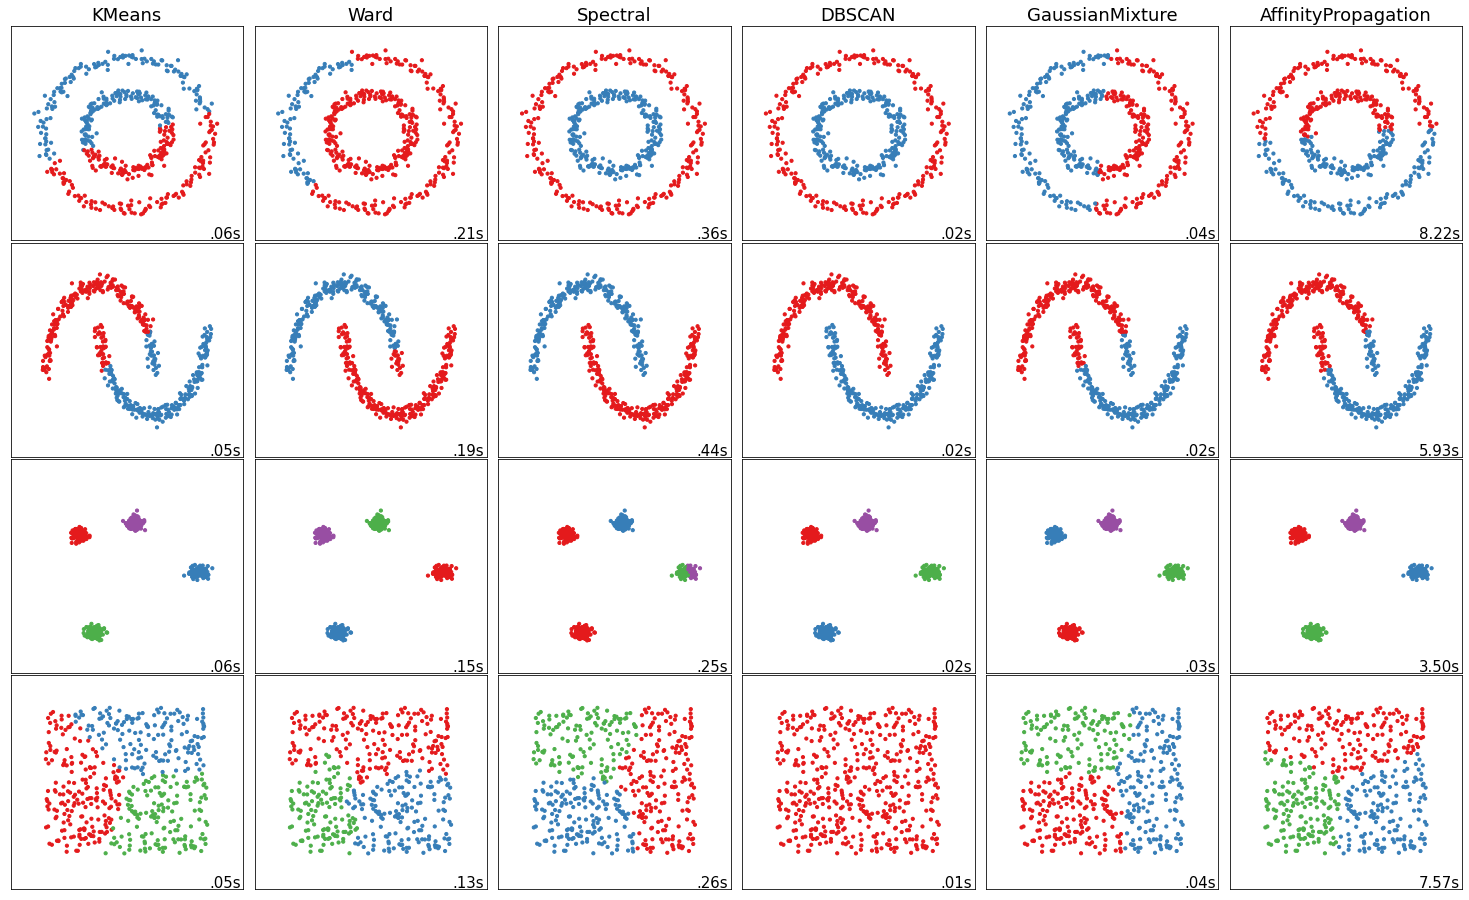

In [38]:
from sklearn.neighbors import kneighbors_graph 
from sklearn import mixture 
import warnings 
from matplotlib import cm

n_samples = 500
circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05, random_state=0)
moons = datasets.make_moons(n_samples=n_samples, noise=.05, random_state=0)
clouds = datasets.make_blobs(n_samples=500, n_features=2, centers=4, center_box=(-20,20), random_state=42)
np.random.seed(0)
block = np.random.rand(n_samples, 2), None

defaults = {'eps': .3,
            'damping_factor': .8,
            'preference': "median",
            'n_clusters': 3,
            'n_neighbors': 10,
            'local_thresh': 70,
            'measure': "eucl"
           }
dsets = [
    (circles, {'damping_factor': .77, 'preference': -300,
               'quantile': .2, 'n_clusters': 2,
               'min_samples': 20, 'xi': 0.25}),
    (moons, {'preference': -220, 'n_clusters': 2}),
    (clouds, {"local_thresh":20, "damping_factor":.77, "n_clusters":4}),
    (block, {"preference":-200})]

plt.figure(figsize=(21, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

for i_dataset, (dataset, aparams) in enumerate(dsets):
    params = defaults.copy()
    params.update(aparams)

    X, Y = dataset
    X = StandardScaler().fit_transform(X)

    # Connectivity for Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    connectivity = 0.5 * (connectivity + connectivity.T)

    # Initialise cluster algorithms
    kmeans = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    gauss = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    algos = (
        ('KMeans', kmeans),
        ('Ward', ward),
        ('Spectral', spectral),
        ('DBSCAN', dbscan),
        ('GaussianMixture', gauss),
        ('AffinityPropagation', None),
    )

    for name, algo in algos:
        if name != "AffinityPropagation":
            t0 = time()
            with warnings.catch_warnings():
                warnings.filterwarnings(
                    "ignore",
                    message="the number of connected components of the " +
                    "connectivity matrix is [0-9]{1,2}" +
                    " > 1. Completing it to avoid stopping the tree early.",
                    category=UserWarning)
                warnings.filterwarnings(
                    "ignore",
                    message="Graph is not fully connected, spectral embedding" +
                    " may not work as expected.",
                    category=UserWarning)
                algo.fit(X)

            t1 = time()
            if hasattr(algo, 'labels_'):
                c_labels = algo.labels_.astype(int)
            else:
                c_labels = algo.predict(X)

        else:
            t0 = time()
            affinity_propagation = affinity_prop(X, maxiter=500, 
                                                 preference=params['preference'],
                                                 damping_factor=params['damping_factor'],
                                                 local_thresh=params['local_thresh'],
                                                 sim_measure=params['measure'],
                                                 verbose=False
                                                 )
            c_labels = affinity_propagation[1]
            t1 = time()
        plt.subplot(len(dsets), len(algos), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = [cm.Set1(k) for k in range(len(np.unique(c_labels)))]
        colors.append((0,0,0,1)) # add black for non-clustered obs
        colors = np.asarray(colors)
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[c_labels])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

Second, we compare how the Affinity Propagation algorithm results differ when using different similarity measures (cosine vs. negative Euclidean distance).

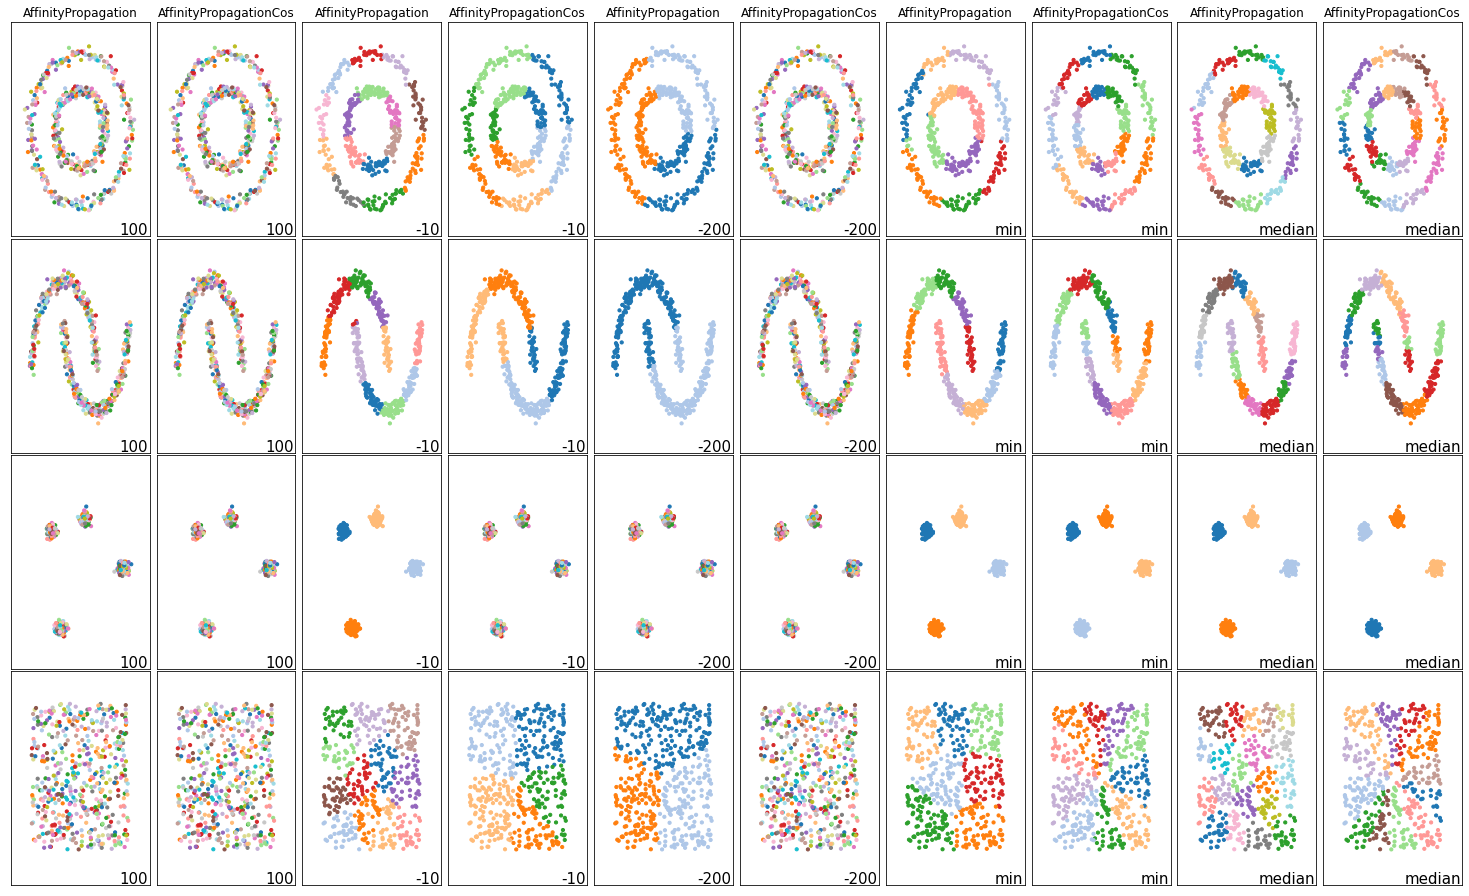

In [32]:
from sklearn.neighbors import kneighbors_graph 
from sklearn import mixture 
import warnings 
from matplotlib import cm

defaults = {'damping_factor': .8,
            'local_thresh': 70,
           }

dsets = [
    (circles, {'damping_factor': .77}),
    (moons, {}),
    (clouds, {"local_thresh":20, "damping_factor":.77}),
    (block, {})]

plt.figure(figsize=(21, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

for i_dataset, (dataset, aparams) in enumerate(dsets):
    params = defaults.copy()
    params.update(aparams)

    X, Y = dataset
    X = StandardScaler().fit_transform(X)

    algos = (
        ('AffinityPropagation', 100),
        ('AffinityPropagationCos', 100),
        ('AffinityPropagation', -10),
        ('AffinityPropagationCos', -10),
        ('AffinityPropagation', -200),
        ('AffinityPropagationCos', -200),
        ('AffinityPropagation', "min"),
        ('AffinityPropagationCos', "min"),
        ('AffinityPropagation', "median"),
        ('AffinityPropagationCos', "median")
    )
    
    for name, pref in algos:
        if name == "AffinityPropagation":
            measure = "eucl"
        else:
            measure = "cos"
        affinity_propagation = affinity_prop(X, maxiter=500, 
                                             preference=pref,
                                             damping_factor=params['damping_factor'],
                                             local_thresh=params['local_thresh'],
                                             sim_measure=measure, verbose=False)

        c_labels = affinity_propagation[1]

        plt.subplot(len(dsets), len(algos), plot_num)
        if i_dataset == 0:
            plt.title(name, size=12)

        # make cyclic colors
        colors = [cm.tab20(k%20) for k in range(len(np.unique(c_labels)))]
        colors.append((0,0,0,1)) # add black for non-clustered obs
        colors = np.asarray(colors)
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[c_labels])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, (pref),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

We also do some perfomance testing against the ***sklearn*** implementation of the algorithm. It turns out, that our algorithm performs better than ***sklean*** on smaller datasets, but does not do so when datasets grow bigger.

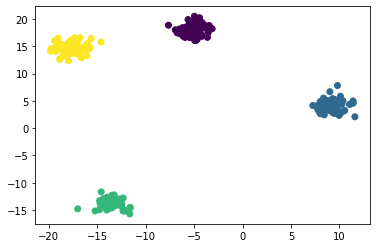

In [15]:
# Create the data and plotting it for inspection
data, labels = datasets.make_blobs(n_samples=250, n_features=2, centers=4, center_box=(-20,20), random_state=42)
plt.scatter(data[:,0],data[:,1], c=labels)
plt.show()

In [74]:
%%timeit 
ap = cluster.AffinityPropagation(convergence_iter=20, damping=.77, random_state=None).fit(data)

456 ms ± 48.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [75]:
%%timeit 
exemplars, labels, centers = affinity_prop(data, maxiter=1000, local_thresh=20, damping_factor=.77,verbose=False)

367 ms ± 31.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Our algorithm is faster!

In [ ]:
ap = cluster.AffinityPropagation(convergence_iter=20, damping=.77, random_state=None).fit(data)
centers2 = ap.cluster_centers_
labels2 = ap.labels_
exemplars2 = ap.cluster_centers_indices_

In [ ]:
exemplars, labels, centers = affinity_prop(data, maxiter=1000, local_thresh=20, damping_factor=.77,verbose=False)

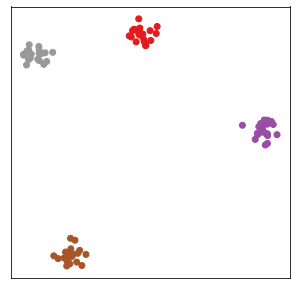

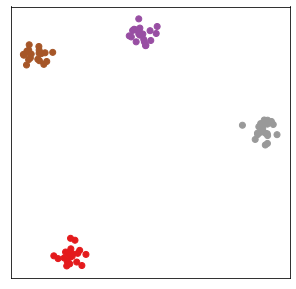

In [58]:
cplot(data,labels)
cplot(data, ap.labels_)

Converged after 100 iterations.


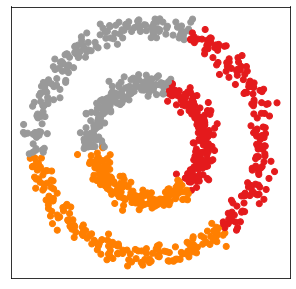

19.133432865142822

In [19]:
n_samples = 1000
np.random.seed(0)
data, labels = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)
X = StandardScaler().fit_transform(data)

t1 = time()
exemplars, labels, centers = affinity_prop(X, damping_factor=0.77, maxiter=500, local_thresh=28, preference=-170)
t2 = time()
# seed 0, 28, -170
cplot(X, labels)
t2-t1

Converged after 65 iterations.


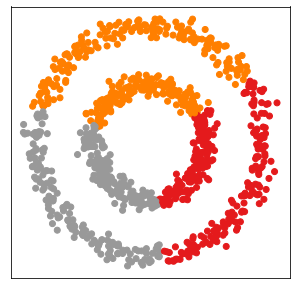

9.300994396209717

In [20]:
np.random.seed(0)
affinity_propagation = cluster.AffinityPropagation(
    damping=.77, preference=-240, convergence_iter=28,
    verbose=True, random_state=0)

t1 = time()
affinity_propagation.fit(X)
t2 = time()

labs = affinity_propagation.labels_.astype(int)
cplot(X, labs)
t2-t1

Our algorithm is slower in this setting!
To identify leftover bottlenecks, we run another round of profiling, but it is hard to implement a single cause. The functions should probably be rewritten in Cython

In [201]:
cProfile.run('affinity_prop(data, maxiter=10)')

Stopped after 10 iterations.
         1006 function calls (969 primitive calls) in 0.048 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(amax)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(amin)
       21    0.000    0.000    0.003    0.000 <__array_function__ internals>:2(argmax)
       12    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(copyto)
       10    0.000    0.000    0.001    0.000 <__array_function__ internals>:2(diag)
       10    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(diagonal)
        1    0.000    0.000    0.012    0.012 <__array_function__ internals>:2(dot)
       12    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(empty_like)
       31    0.000    0.000    0.001    0.000 <__array_function__ internals>:2(fill_diagonal)
        1    